# Sentiment analysis of online reviews.

## a) Parse file

In [1]:
import numpy as np
from matplotlib import pylab as plt
import matplotlib.cm as cm
%matplotlib inline

In [2]:
sentence = []
label = []

In [3]:
def readFile(filePath, sentence, label):
    for line in open(filePath):
        tokens = line.strip().split("\t")
        sentence.append(tokens[0])
        label.append(tokens[1])

In [4]:
readFile("./data/amazon_cells_labelled.txt", sentence, label)

In [5]:
readFile("./data/imdb_labelled.txt", sentence, label)

In [6]:
readFile("./data/yelp_labelled.txt", sentence, label)

In [7]:
sentence = np.array(sentence)
label = np.array(label)

#### There are 500 positive and 500 negative sentences each set, so the labels are balanced according to README included with the data.

#### We process it by appending them to 2 np arrays. One for sentence and one for its label.

## b) Preprocessing Strategy

### b.1 Lowercase all words for ease of word matching

In [8]:
sentence = np.char.lower(sentence)

In [9]:
sentence[0]

'so there is no way for me to plug it in here in the us unless i go by a converter.'

### b.2 Lemmatization of all words helps cluster words with same meaning

### b.3 Strip the stopwords. Remove words like 'the', 'is', 'are' which have no value in our analysis

### b.3 Strip Punctuation. Punctuation again does not provide any value in matching. So remove it can possibly improve accuracy.

In [10]:
import re
# nltk.download() if not installed nltk
from nltk.corpus import stopwords  # Stopwords: ‘the’, ‘is’, ‘are’...
from nltk.stem.porter import * # Stem: gamer, gaming, game -> game
from nltk.tokenize import RegexpTokenizer # Regexp: set rule to just tokenize word

In [11]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+')

In [12]:
for i in range(len(sentence)):
    words = []
    for word in tokenizer.tokenize(sentence[i]): # Remove punctuation
        if word not in stop_words: # Remove stopwords
            words.append(stemmer.stem(word)) # Stem word
        sentence[i] = " ".join(words)

In [13]:
sentence[0]

'way plug us unless go convert'

## c) Split training and testing set: use the first 400 instances for EACH label as the training set and the remaining 100 instances as testing set.

In [14]:
train_data, train_label = [],[]
test_data, test_label = [],[]

In [15]:
u_labels = np.unique(label) # unique labels
u_labels

array(['0', '1'],
      dtype='<U1')

In [16]:
for file in range(0,3):    
    label_count = [0] * len(u_labels) # array to count each label type
    for i in range(file*1000, file*1000 + 1000):
        for l in range(len(u_labels)):
            if label[i] == u_labels[l]:
                label_count[l] = label_count[l] + 1
                if label_count[l] <= 400:
                    train_data.append(sentence[i])
                    train_label.append(u_labels[l])
                else:
                    test_data.append(sentence[i])
                    test_label.append(u_labels[l])

In [17]:
train_data = np.array(train_data)
test_data = np.array(test_data)
train_label = np.array(train_label)
test_label = np.array(test_label)

In [18]:
len(train_data)

2400

In [19]:
len(test_data)

600

## d) Bag of Words Model

#### Dictionary of unique words from training set. We don't use testing set here because this is training step. If we use test data here, the model will overfit.

In [20]:
dict = {}
i = 0
for line in train_data:
    for word in line.split():
        if word not in dict:
            dict[word] = i
            i = i + 1

In [21]:
length = len(dict)
length

3500

#### Count occurence of word in each review

In [22]:
train_feature = []
test_feature = []

In [23]:
for line in train_data:
    freq = [0] * length
    for word in line.split():
        freq[dict[word]] += 1
    train_feature.append(freq)

In [24]:
for line in test_data:
    freq = [0] * length
    for word in line.split():
        if word in dict:
            freq[dict[word]] +=1
    test_feature.append(freq)

#### Present any 2 reviews in training set

In [25]:
train_feature = np.array(train_feature, dtype=float)

In [26]:
train_data[0]

'way plug us unless go convert'

In [27]:
train_feature[0]

array([ 1.,  1.,  1., ...,  0.,  0.,  0.])

In [28]:
train_data[1]

'good case excel valu'

In [29]:
train_feature[1]

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [30]:
test_feature = np.array(test_feature, dtype=float)

## e) Postprocessing Strategy

In [31]:
from sklearn import preprocessing

In [32]:
train_post_l2 = preprocessing.normalize(train_feature, norm='l2')

In [33]:
test_post_l2 = preprocessing.normalize(test_feature, norm='l2')

In [34]:
train_post_l1 = preprocessing.normalize(train_feature, norm='l1')

In [35]:
test_post_l1 = preprocessing.normalize(test_feature, norm='l1')

#### We employ both l1 and l2 norm since they are effective on sparse data. l2 pull its elements into sphere. l1 pulls its elements into a square shaped target. Either way, they all force the elements come closer together in term of similarity.

#### As we can see from the scores below, L2 does better than L1 in Logistic Regression.
#### But in Naive Bayes, L1 does better than L2.

## f) Sentiment Prediction

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import itertools #iterator for looping

In [37]:
def plot_confusion_matrix(test_label, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(test_label, y_pred)
    plt.figure()
    classes = {"0", "1"}
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Accent)
    plt.title(title)    
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]    
    threshold = cm.max() / 2;

    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black")
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [38]:
def calculate_model(model, train_data, train_label, test_data, test_label, dictionary, title):
    # Caluclate Accuracy
    model.fit(train_data, train_label)
    score = model.score(test_data, test_label)
    print("Accuracy: {}".format(score))
    
    # Plot Confusion Matrix
    y_pred = model.predict(test_data)
    np.set_printoptions(precision=2)
    plot_confusion_matrix(test_label, y_pred, title=title)
    
    
    # What are the words that play the most important roles in deciding the sentiment of the reviews?
    if hasattr(model, 'coef_'):
        coeff = np.argsort(np.absolute(model.coef_))[0]
        significant = coeff[::-1][:20]
        print("Weights: ", significant)
        print("20 Significant Words:")
        for i in significant:
            for w in dictionary.keys():
                if dictionary[w] == i:
                    print(w)

### Logistic Regrssion Model

Regression Model with L1 norm
Accuracy: 0.775


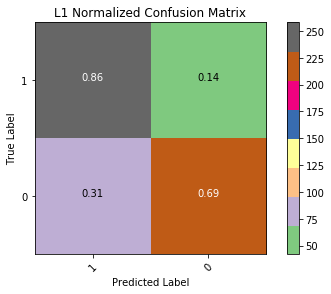

Weights:  [  10  223   95    8    6  170  113  161   40 2924  144  915  664  571  454
  190  708  173  505 1088]
20 Significant Words:
great
bad
love
excel
good
nice
best
poor
wast
delici
well
amaz
terribl
worst
fantast
disappoint
suck
price
awesom
aw


In [39]:
print("Regression Model with L1 norm")
calculate_model(LogisticRegression(), train_post_l1, train_label, test_post_l1, test_label, dict,title="L1 Normalized Confusion Matrix")

Regression Model with L2 norm
Accuracy: 0.8166666666666667


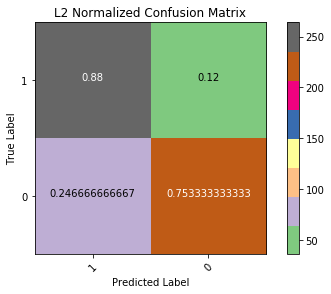

Weights:  [  10   95  223    8  170 2924  915  161    6  113  571  454  664  144   40
  505  279  708   65 1088]
20 Significant Words:
great
love
bad
excel
nice
delici
amaz
poor
good
best
worst
fantast
terribl
well
wast
awesom
beauti
suck
comfort
aw


In [40]:
print("Regression Model with L2 norm")
calculate_model(LogisticRegression(), train_post_l2, train_label, test_post_l2, test_label, dict,title="L2 Normalized Confusion Matrix")

### Naive Bayes Model

In [41]:
from sklearn.naive_bayes import GaussianNB

Naive Bayes Model with L1 norm
Accuracy: 0.7133333333333334


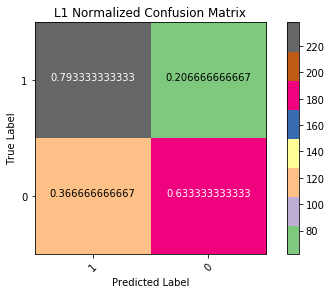

In [42]:
print("Naive Bayes Model with L1 norm")
calculate_model(GaussianNB(), train_post_l1, train_label, test_post_l1, test_label, dict,title="L1 Normalized Confusion Matrix")

Naive Bayes Model with L2 norm
Accuracy: 0.6966666666666667


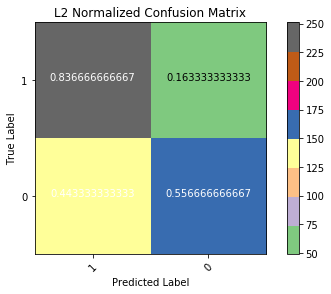

In [43]:
print("Naive Bayes Model with L2 norm")
calculate_model(GaussianNB(), train_post_l2, train_label, test_post_l2, test_label, dict,title="L2 Normalized Confusion Matrix")

## g) N-gram Model

### N-gram

In [44]:
def ngram(text,n):  
    model=[]  
    words = text.split()
    if len(words) <= n:
        return [text]
    for i in range(len(words) - n + 1):
        model.append(" ".join(words[i:i+n]))
    return model

### Index words

In [45]:
def make_ng_dict(n):
    nword_index = {}
    i = 0
    
    for line in train_data:
        for nw in ngram(line, n):
            if nw not in nword_index:
                nword_index[nw] = i;
                i = i + 1
    return nword_index

In [46]:
nword_index = make_ng_dict(2)

### Create Feature Vectors

In [47]:
def feature_ng(data, word_index, n):
    fea_v = []
    w_count = len(word_index)

    for line in data:
        freq = [0] * w_count
        for nw in ngram(line,n):
            if nw in nword_index:
                freq[nword_index[nw]] += 1
        fea_v.append(freq)
    return np.array(fea_v)
        

In [48]:
train_feature_ng = feature_ng(train_data, nword_index, 2)

In [49]:
test_feature_ng = feature_ng(test_data, nword_index, 2)

### Post Process. 

In [50]:
train_post_l1_ng = preprocessing.normalize(train_feature_ng, norm='l1')

In [51]:
test_post_l1_ng = preprocessing.normalize(test_feature_ng, norm='l1')

In [52]:
train_post_l2_ng = preprocessing.normalize(train_feature_ng, norm='l2')

In [53]:
test_post_l2_ng = preprocessing.normalize(test_feature_ng, norm='l2')

### Sentiment Prediction

#### Logistic Regression

Logistic Regression Model with L1 norm
Accuracy: 0.6433333333333333


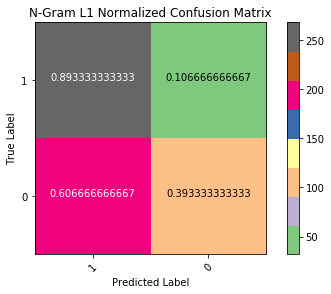

Weights:  [  71   63  622  783   37  243  516 3840 9321  368 4201 3110  975 7960 1121
  761  413  342 8186  968]
20 Significant Words:
work great
highli recommend
wast time
great phone
wast money
disappoint
great product
10 10
food good
easi use
love
horribl
custom servic
love place
good price
buy product
one best
love phone
great food
make mistak


In [54]:
print("Logistic Regression Model with L1 norm")
calculate_model(LogisticRegression(), train_post_l1_ng, train_label, test_post_l1_ng, test_label, nword_index,title="N-Gram L1 Normalized Confusion Matrix")

Regression Model with L2 norm
Accuracy: 0.645


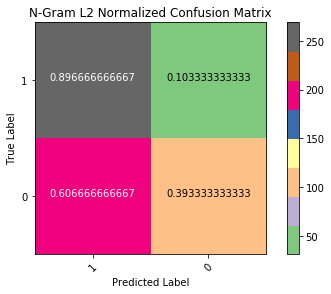

Weights:  [  71   63  622  413  783  243   37  516 3840 9321  368  975 8186 4958 1121
 7960 4201 2100 8424 3110]
20 Significant Words:
work great
highli recommend
wast time
one best
great phone
disappoint
wast money
great product
10 10
food good
easi use
custom servic
great food
realli good
good price
love place
love
great servic
food delici
horribl


In [55]:
print("Regression Model with L2 norm")
calculate_model(LogisticRegression(), train_post_l2_ng, train_label, test_post_l2_ng, test_label, nword_index,title="N-Gram L2 Normalized Confusion Matrix")

#### Naive Bayes

Naive Bayes Model with L1 norm
Accuracy: 0.64


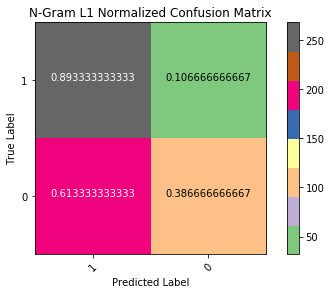

In [56]:
print("Naive Bayes Model with L1 norm")
calculate_model(GaussianNB(), train_post_l1_ng, train_label, test_post_l1_ng, test_label, nword_index,title="N-Gram L1 Normalized Confusion Matrix")

Naive Bayes Model with L2 norm
Accuracy: 0.635


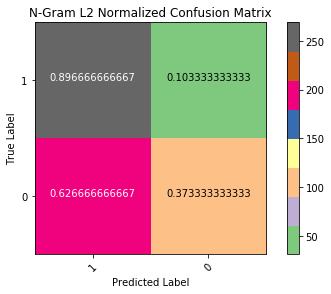

In [57]:
print("Naive Bayes Model with L2 norm")
calculate_model(GaussianNB(), train_post_l2_ng, train_label, test_post_l2_ng, test_label, nword_index,title="N-Gram L2 Normalized Confusion Matrix")

## h) PCA for bag of words model

In [58]:
# http://sebastianraschka.com/Articles/2014_pca_step_by_step.html
#Take the whole dataset consisting of dd-dimensional samples ignoring the class labels
def pca(dataset, test, n):
    #Compute the dd-dimensional mean vector 
    mean = dataset.mean(axis=0)
    dataset -= mean
    
    #Compute the scatter matrix (alternatively, the covariance matrix) of the whole data set
    cov_mx = np.cov(dataset, rowvar=False)
    
    #Compute eigenvectors (ee1,ee2,...,eedee1,ee2,...,eed) and corresponding eigenvalues (λλ1,λλ2,...,λλdλλ1,λλ2,...,λλd)
    evals, evecs = np.linalg.eigh(cov_mx)
    
    #Sort the eigenvectors by decreasing eigenvalues and choose kk eigenvectors with the largest eigenvalues to form a d×kd×k dimensional matrix W
    i = np.argsort(evals)[::-1]
    
    #Use this d×kd×k eigenvector matrix to transform the samples onto the new subspace.
    evecs = evecs[:, i]
    evecs = evecs[:, :n]
    
    evals = evals[i]
    evals = evals[:n]
    
    return np.dot(evecs.T, dataset.T).T, np.dot(evecs.T, (test-mean).T).T

#### Use data in e

In [60]:
train_pca_10_l2, test_pca_10_l2 = pca(train_post_l2, test_post_l2, 10)

In [61]:
train_pca_50_l2,test_pca_50_l2 = pca(train_post_l2,test_post_l2, 50)

In [62]:
train_pca_100_l2,test_pca_100_l2 = pca(train_post_l2, test_post_l2, 100)

#### Repeat in f

PCA 10 Regression Model with L2 norm
Accuracy: 0.625


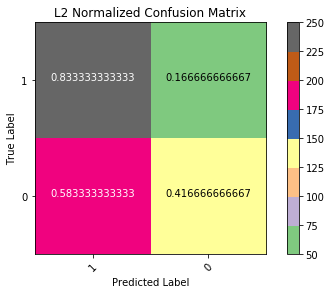

Weights:  [0 1 8 7 5 3 9 4 2 6]
20 Significant Words:
way
plug
excel
case
convert
unless
valu
go
us
good
PCA 10 Naive Bayes Model with L2 norm
Accuracy: 0.5816666666666667


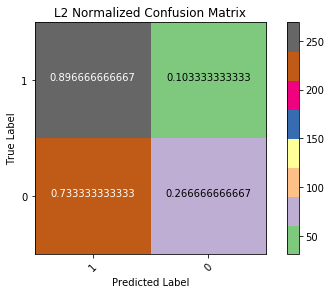

In [63]:
print("PCA 10 Regression Model with L2 norm")
calculate_model(LogisticRegression(), train_pca_10_l2, train_label, test_pca_10_l2, test_label, dict,title="L2 Normalized Confusion Matrix")

print("PCA 10 Naive Bayes Model with L2 norm")
calculate_model(GaussianNB(), train_pca_10_l2, train_label, test_pca_10_l2, test_label, dict,title="L2 Normalized Confusion Matrix")

PCA 50 Regression Model with L2 norm
Accuracy: 0.6916666666666667


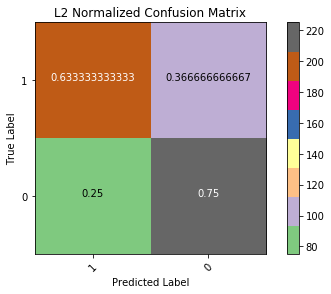

Weights:  [ 0 25  1 31 36 11  8  7 19 12 26 20 18 24 30 35 23 13 46  5]
20 Significant Words:
way
decent
plug
imagin
owner
jawbon
excel
case
problem
tie
volum
mic
major
right
contact
razr
line
charger
origin
convert
PCA 50 Naive Bayes Model with L2 norm
Accuracy: 0.6383333333333333


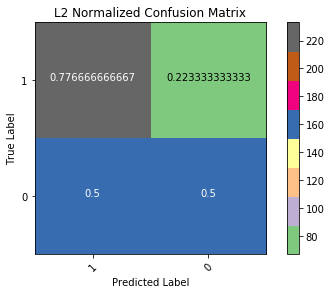

In [64]:
print("PCA 50 Regression Model with L2 norm")
calculate_model(LogisticRegression(), train_pca_50_l2, train_label, test_pca_50_l2, test_label, dict,title="L2 Normalized Confusion Matrix")

print("PCA 50 Naive Bayes Model with L2 norm")
calculate_model(GaussianNB(), train_pca_50_l2, train_label, test_pca_50_l2, test_label, dict,title="L2 Normalized Confusion Matrix")

PCA 100 Regression Model with L2 norm
Accuracy: 0.73


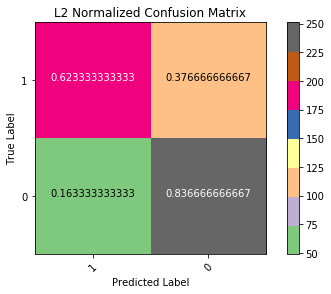

Weights:  [ 0 25  1 82 68 31 36 11  8 52  7 19 12 71 91 93 97 96 51 26]
20 Significant Words:
way
decent
plug
would
blue
imagin
owner
jawbon
excel
5
case
problem
tie
advis
use
fire
mislead
commerci
mere
volum
PCA 100 Naive Bayes Model with L2 norm
Accuracy: 0.65


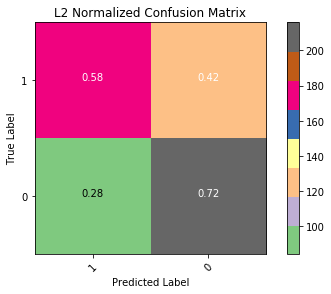

In [65]:
print("PCA 100 Regression Model with L2 norm")
calculate_model(LogisticRegression(), train_pca_100_l2, train_label, test_pca_100_l2, test_label, dict,title="L2 Normalized Confusion Matrix")

print("PCA 100 Naive Bayes Model with L2 norm")
calculate_model(GaussianNB(), train_pca_100_l2, train_label, test_pca_100_l2, test_label, dict,title="L2 Normalized Confusion Matrix")


#### Repeat in g

In [67]:
train_post_pca_10_l2_ng, test_post_pca_10_l2_ng = pca(train_post_l2_ng, test_post_l2_ng, 10)

In [69]:
train_post_pca_50_l2_ng, test_post_pca_50_l2_ng = pca(train_post_l2_ng, test_post_l2_ng, 50)

In [68]:
train_post_pca_100_l2_ng, test_post_pca_100_l2_ng = pca(train_post_l2_ng, test_post_l2_ng, 100)

PCA 10 Regression Model with L2 norm N-Gram
Accuracy: 0.5283333333333333


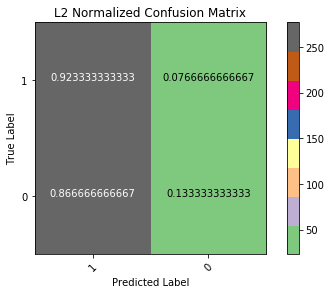

Weights:  [0 5 6 3 4 2 1 8 9 7]
20 Significant Words:
way plug
good case
case excel
unless go
go convert
us unless
plug us
great jawbon
tie charger
excel valu
PCA 10 Naive Bayes Model with L2 norm N-Gram
Accuracy: 0.5116666666666667


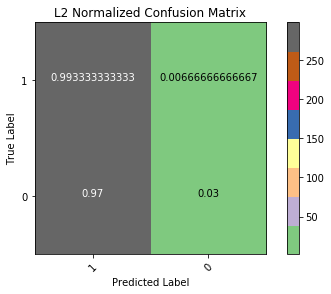

In [70]:
print("PCA 10 Regression Model with L2 norm N-Gram")
calculate_model(LogisticRegression(), train_post_pca_10_l2_ng, train_label, test_post_pca_10_l2_ng, test_label, nword_index,title="L2 Normalized Confusion Matrix")

print("PCA 10 Naive Bayes Model with L2 norm N-Gram")
calculate_model(GaussianNB(), train_post_pca_10_l2_ng, train_label, test_post_pca_10_l2_ng, test_label, nword_index,title="L2 Normalized Confusion Matrix")


PCA 50 Regression Model with L2 norm N-Gram
Accuracy: 0.525


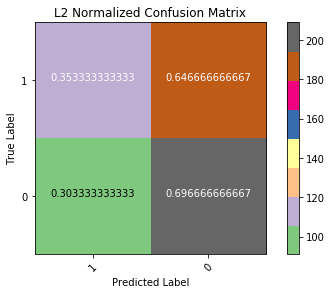

Weights:  [ 0  5 11 30  6 22 29 42  3 17 23 37 38 19 27 26  4 31 25 24]
20 Significant Words:
way plug
good case
convers last
fun send
case excel
get decent
imagin fun
go origin
unless go
jiggl plug
decent volum
wast money
money time
get line
hundr contact
sever hundr
go convert
send one
dozen sever
sever dozen
PCA 50 Naive Bayes Model with L2 norm N-Gram
Accuracy: 0.5716666666666667


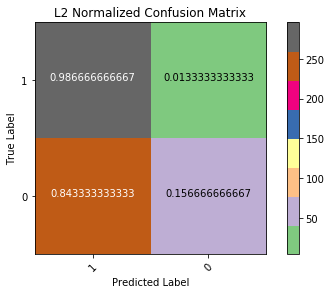

In [71]:
print("PCA 50 Regression Model with L2 norm N-Gram")
calculate_model(LogisticRegression(), train_post_pca_50_l2_ng, train_label, test_post_pca_50_l2_ng, test_label, nword_index,title="L2 Normalized Confusion Matrix")

print("PCA 50 Naive Bayes Model with L2 norm N-Gram")
calculate_model(GaussianNB(), train_post_pca_50_l2_ng, train_label, test_post_pca_50_l2_ng, test_label, nword_index,title="L2 Normalized Confusion Matrix")


PCA 100 Regression Model with L2 norm N-Gram
Accuracy: 0.5333333333333333


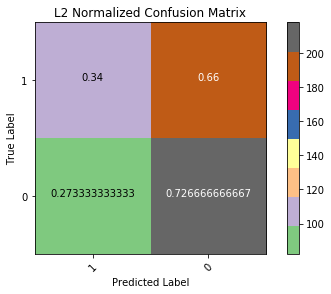

Weights:  [ 0  5 11 30  6 22 29 42  3 17 23 37 38 19 84 27 26 92  4 31]
20 Significant Words:
way plug
good case
convers last
fun send
case excel
get decent
imagin fun
go origin
unless go
jiggl plug
decent volum
wast money
money time
get line
direct could
hundr contact
sever hundr
commerci mislead
go convert
send one
PCA 100 Naive Bayes Model with L2 norm N-Gram
Accuracy: 0.5716666666666667


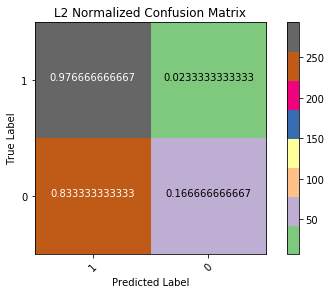

In [72]:
print("PCA 100 Regression Model with L2 norm N-Gram")
calculate_model(LogisticRegression(), train_post_pca_100_l2_ng, train_label, test_post_pca_100_l2_ng, test_label, nword_index,title="L2 Normalized Confusion Matrix")

print("PCA 100 Naive Bayes Model with L2 norm N-Gram")
calculate_model(GaussianNB(), train_post_pca_100_l2_ng, train_label, test_post_pca_100_l2_ng, test_label, nword_index,title="L2 Normalized Confusion Matrix")
